In [ ]:
%pip install einops
%pip install wandb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from einops import rearrange, repeat
from einops.layers.tensorflow import Rearrange, Reduce

class MLPBlock(layers.Layer):
    def __init__(self, mixing, d_ff):
        super(MLPBlock, self).__init__()
        if mixing != 'token' and mixing != 'channel':
            raise ValueError("undefiend mixing")
        self.mixing = mixing
        self.d_ff = d_ff
        
    def build(self, input_shape):
        d_out = input_shape[-1] if self.mixing=='channel' else input_shape[-2]
        self.dense_1 = layers.Dense(self.d_ff, use_bias=False)
        self.dense_2 = layers.Dense(d_out, use_bias=False)
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        '''
        inputsは(batches, tokens, channels)
        Denseは最後の軸に作用
        '''
        x = self.norm(inputs)
        x = x if self.mixing!='token' else tf.transpose(x, perm=[0, 2, 1])
        x =self.dense_1(x)
        x = tf.keras.activations.gelu(x, approximate=True)
        x = self.dense_2(x)
        x = x if self.mixing!='token' else tf.transpose(x, perm=[0, 2, 1])
        return x + inputs

class MixerBlock(layers.Layer):
    def __init__(self, d_s, d_c):
        super(MixerBlock, self).__init__()
        self.mlp_1 = MLPBlock(mixing='token', d_ff=d_s)
        self.mlp_2 = MLPBlock(mixing='channel', d_ff=d_c)

    def call(self, inputs):
        x = self.mlp_1(inputs)
        x = self.mlp_2(x)
        return x


def build_model(**config):
    shapes = (config['image_size'], config['image_size'], config['channels'])
    hidden_dim  = config['hidden_dim']
    patch_size = config['patch_size']
    num_blocks = config['depth']
    tokens_mlp_dim = config['tokens_mlp_dim']
    channels_mlp_dim = config['channels_mlp_dim']
    num_classes = config['num_classes']
    size = (config['image_size']//config['patch_size'])  #4

    inputs = layers.Input(shape=shapes)
    x = Rearrange('b (h x) (w y) c -> b (h w) (x y c)', x=size, y=size)(inputs) #(B, 64, 48)
    x = layers.Dense(hidden_dim, use_bias=False)(x)

    for i in range(num_blocks):
      x = MixerBlock(tokens_mlp_dim, channels_mlp_dim)(x)
    
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In [ ]:
model = build_model(**config)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rearrange_2 (Rearrange)      (None, 64, 48)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64, 64)            3072      
_________________________________________________________________
mixer_block_8 (MixerBlock)   (None, 64, 64)            82176     
_________________________________________________________________
mixer_block_9 (MixerBlock)   (None, 64, 64)            82176     
_________________________________________________________________
mixer_block_10 (MixerBlock)  (None, 64, 64)            82176     
_________________________________________________________________
mixer_block_11 (MixerBlock)  (None, 64, 64)            8217

In [ ]:
config={
    "epochs": 64, 
    "batch_size": 256,
    "lr" : 1e-6,
    "image_size" : 32,
    "channels" : 3,
    "num_classes" : 10,
    "hidden_dim" : 64,
    "patch_size" : 8,
    "depth" : 4,
    "tokens_mlp_dim" : 128,
    "channels_mlp_dim" : 512,
    }


import wandb
wandb.init(config=config, project="Cifar10_MLP_Mixer", entity='NoguNogu',name='MLP_Mixer1')

epoch,2
loss,1.45923
accuracy,0.4732
val_loss,1.41321
val_accuracy,0.4842
lr,0.001
_runtime,62
_timestamp,1622462387
_step,2
best_val_loss,1.41321
best_epoch,2


epoch,▁▅█
loss,█▃▁
accuracy,▁▆█
val_loss,█▄▁
val_accuracy,▁▅█
lr,▁▁▁
_runtime,▁▅█
_timestamp,▁▅█
_step,▁▅█


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

class PatchImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def flow(self, *args, **kwargs):
        batches = super().flow(*args, **kwargs)
        while True:
            batch_x, batch_y = next(batches)
            yield (batch_x, batch_y)
            
    def flow_from_directory(self, *args, **kwargs):
        batches = super().flow_from_directory(*args, **kwargs)
        while True:
            batch_x, batch_y = next(batches)
            yield (batch_x, batch_y)


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255.
y_train = to_categorical(y_train, 10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

train_datagen = PatchImageDataGenerator(rotation_range=5,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = train_datagen.flow(x_train, y_train, batch_size=config['batch_size'])


In [ ]:
p = config['patch_size'] #p=8
img_size = x_train.shape[1]
size = img_size//p # patchのサイズ

img_array = rearrange(x_train, 'b (h x) (w y) c -> b (h w) (x y c)', x=size, y=size)
print(img_array.shape)
img_array = rearrange(x_train, 'b (h x) (w y) c -> b (h w) x y c', x=size, y=size)
print(img_array.shape)

(45000, 64, 48)
(45000, 64, 4, 4, 3)


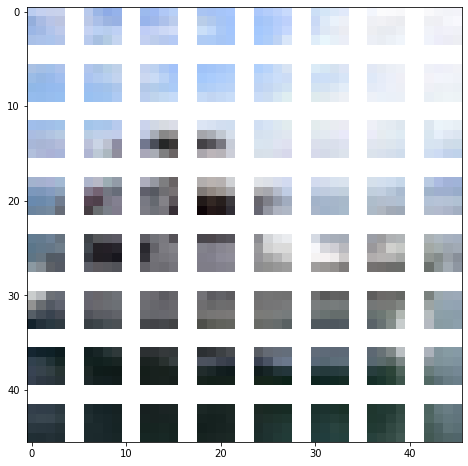

In [ ]:
steps = (img_size-size)//size+1 # 一辺の分割回数、今のストライドなら=P
full_img = np.ones(((size+2)*steps-2, (size+2)*steps-2, 3))
batch_idx = -1

for i in range(steps):
  for j in range(steps):
    idx = i*steps+j
    full_img[(size+2)*i:(size+2)*i+size, (size+2)*j:(size+2)*j+size, :] = img_array[batch_idx, idx]

plt.figure(figsize=(8,8))
plt.imshow(full_img)

In [ ]:
from wandb.keras import WandbCallback

def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

N_train = x_train.shape[0]
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator, 
                    validation_data=(x_val, y_val),
                    steps_per_epoch=N_train//config['batch_size'],
                    epochs= config['epochs'],
                    verbose=1,
                    callbacks=[callback,
                               WandbCallback()],
                    )

Epoch 1/64
175/175 [==============================] - 22s 106ms/step - loss: 1.9352 - accuracy: 0.3000 - val_loss: 1.6871 - val_accuracy: 0.3884


wandb: ERROR Can't save model, h5py returned error: Layer MixerBlock has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/64
175/175 [==============================] - 18s 103ms/step - loss: 1.5927 - accuracy: 0.4271 - val_loss: 1.5211 - val_accuracy: 0.4494
Epoch 3/64
175/175 [==============================] - 18s 103ms/step - loss: 1.4717 - accuracy: 0.4655 - val_loss: 1.4169 - val_accuracy: 0.4880
Epoch 4/64
175/175 [==============================] - 18s 103ms/step - loss: 1.3972 - accuracy: 0.4940 - val_loss: 1.3399 - val_accuracy: 0.5140
Epoch 5/64
175/175 [==============================] - 18s 102ms/step - loss: 1.3432 - accuracy: 0.5152 - val_loss: 1.3771 - val_accuracy: 0.5060
Epoch 6/64
175/175 [==============================] - 18s 103ms/step - loss: 1.2907 - accuracy: 0.5364 - val_loss: 1.3294 - val_accuracy: 0.5264
Epoch 7/64
175/175 [==============================] - 18s 103ms/step - loss: 1.2607 - accuracy: 0.5473 - val_loss: 1.2708 - val_accuracy: 0.5392
Epoch 8/64
175/175 [==============================] - 18s 103ms/step - loss: 1.2214 - accuracy: 0.5601 - val_loss: 1.3316 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.5, 77.5, 77.5, -0.5)

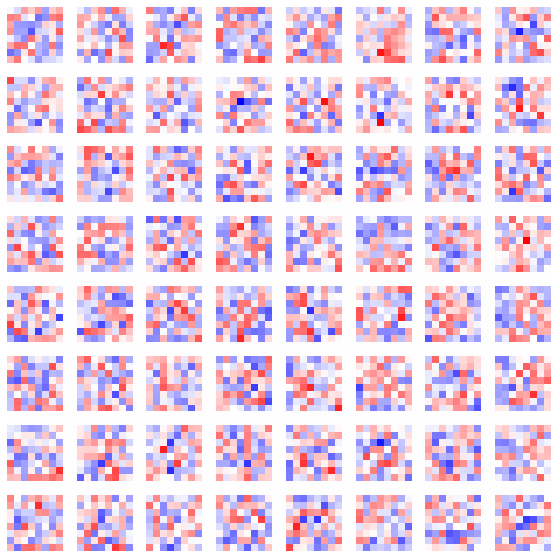

In [ ]:
import matplotlib.colors as mcolors

norm = mcolors.DivergingNorm(vcenter=0.0)

weights = model.layers[3].get_weights()[0].reshape((config['patch_size'], config['patch_size'], config['tokens_mlp_dim']))
num_h = int(np.sqrt(config['hidden_dim']))
num_w = config['hidden_dim']//num_h
full_img = np.zeros(((config['patch_size']+2)*num_h-2, (config['patch_size']+2)*num_w-2))

for i in range(num_h):
  for j in range(num_w):
    idx = config['patch_size']*i+j
    full_img[(config['patch_size']+2)*i:(config['patch_size']+2)*i+config['patch_size'], (config['patch_size']+2)*j:(config['patch_size']+2)*j+config['patch_size']] = weights[:, :, idx]

plt.figure(figsize=(10,10))
plt.imshow(full_img, cmap='bwr', norm=norm)
plt.axis("off")